In [1]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from ProjectPaths import ProjectPaths
%matplotlib inline

In [2]:
image_path = r"/home/tdjg/Documents/DeepSolaris/"

In [3]:
images = np.load(os.path.join(image_path, "hr_2018_18m_all.npy"))
labels = np.load(os.path.join(image_path, "hr_2018_18m_all_labels.npy"))

In [4]:
positives = images[labels == 1, :, :, :]

(<matplotlib.image.AxesImage at 0x7fcc0d58e5f8>, (187, 187, 3))

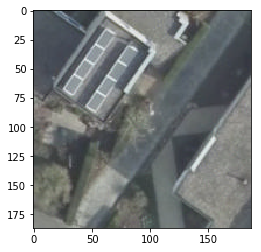

In [5]:
image = positives[0][:,:,::-1]
plt.imshow(image), image.shape

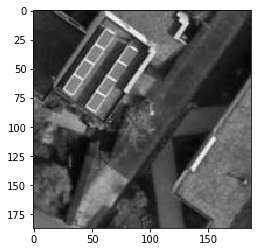

In [6]:
gray = cv2.cvtColor(positives[0], cv2.COLOR_BGR2GRAY)
plt.imshow(gray, cmap='gray')

In [ ]:
!pip install imutils

In [7]:
import imutils

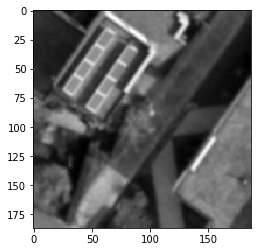

In [8]:
gray = cv2.cvtColor(positives[0], cv2.COLOR_BGR2GRAY)
blurred_image = cv2.GaussianBlur(gray, (5,5),0)
plt.imshow(blurred_image, cmap="gray")

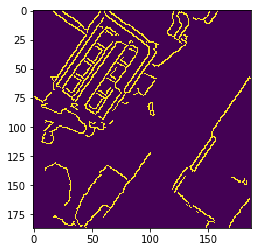

In [9]:
canny_image = imutils.auto_canny(blurred_image)
plt.imshow(canny_image)

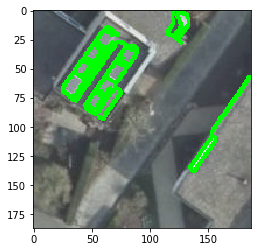

In [10]:
cnts = cv2.findContours(canny_image.copy(), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = sorted(cnts, key=cv2.contourArea, reverse=True)

cnts = cnts[:5]

i = image.copy()
for c in cnts:
    cv2.drawContours(i, [c], -1, (0, 255, 0), 2)
    
plt.imshow(i)

In [11]:
def get_contours(image, number_of_contours=5):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blur_image = cv2.blur(gray_image, (3,3))
    edge_image = imutils.auto_canny(blur_image)
    
    cnts = cv2.findContours(edge_image.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)

    cnts = cnts[:number_of_contours]

    i = image.copy()
    for c in cnts:
        cv2.drawContours(i, [c], -1, (0, 255, 0), 2)
    return i

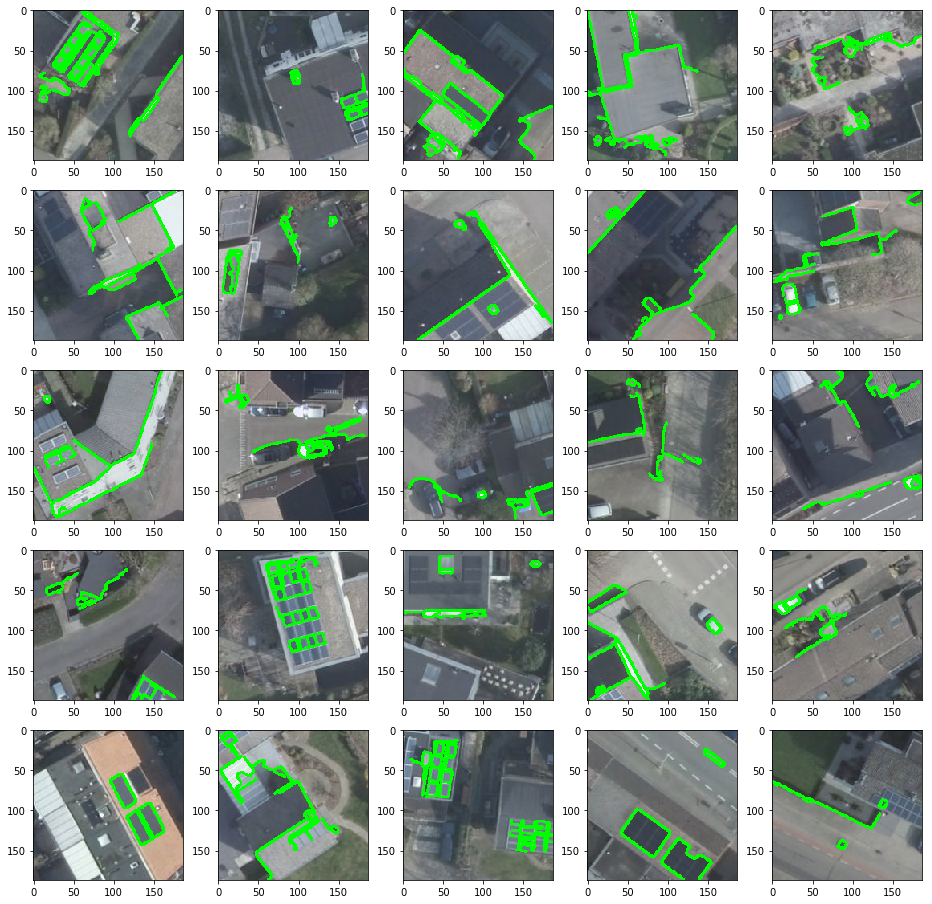

In [12]:
n_rows = 5
n_cols = 5

_, ax = plt.subplots(n_rows, n_cols, figsize=(16, 16))

i = 0
for r in range(n_rows):
    for c in range(n_cols):
        im = get_contours(positives[i])
        ax[r,c].imshow(im[:, :, ::-1])
        i += 1


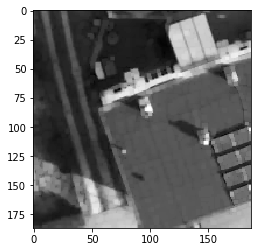

In [13]:
gray = cv2.cvtColor(positives[1], cv2.COLOR_BGR2GRAY)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
opening = cv2.morphologyEx(gray, cv2.MORPH_OPEN, kernel)
plt.imshow(opening, cmap="gray")

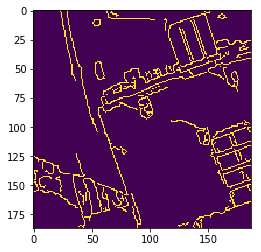

In [14]:
canny_image = imutils.auto_canny(opening)
plt.imshow(canny_image)

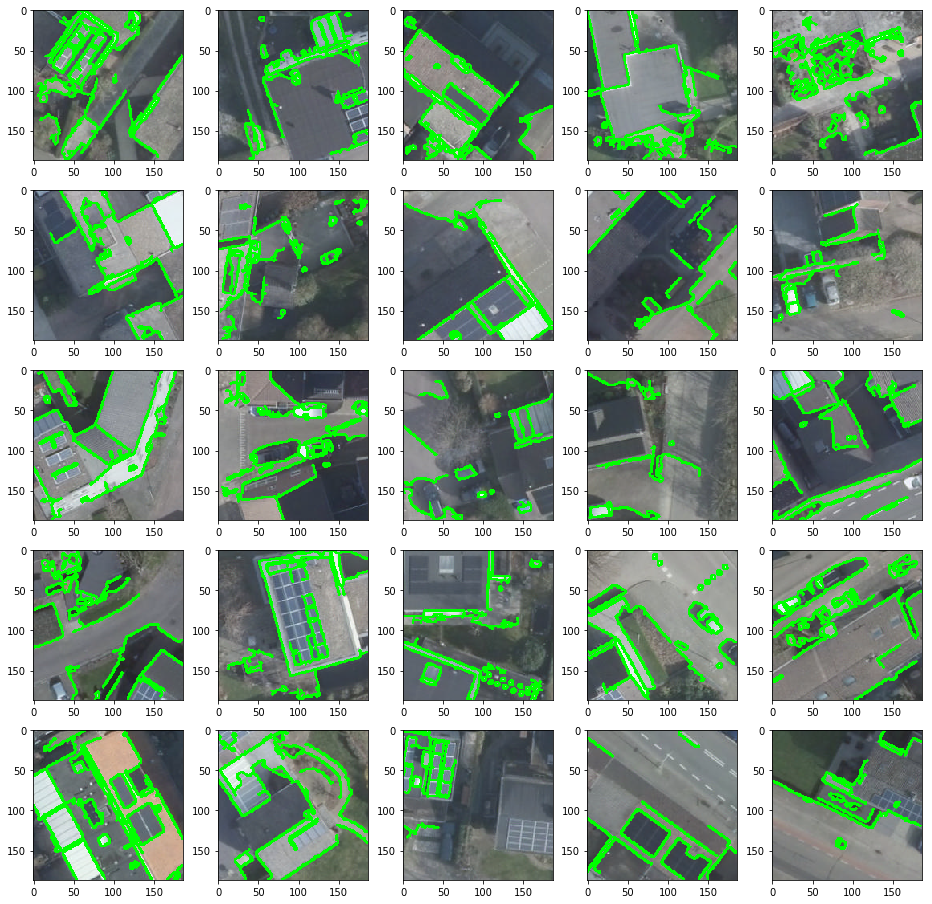

In [15]:
n_rows = 5
n_cols = 5

_, ax = plt.subplots(n_rows, n_cols, figsize=(16, 16))

i = 0
for r in range(n_rows):
    for c in range(n_cols):
        image = positives[i]
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        opening = cv2.morphologyEx(gray, cv2.MORPH_OPEN, kernel)  
        canny_image = imutils.auto_canny(opening)
        
        cnts = cv2.findContours(canny_image.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        cnts = sorted(cnts, key=cv2.contourArea, reverse=True)

        cnts = [cnt for cnt in cnts if cv2.contourArea(cnt) > 15]
        contour_image = image.copy()
        for cnt in cnts:
            peri = cv2.arcLength(cnt, True)
            #approx = cv2.approxPolyDP(cnt, 0.01 * peri, True)
            
            #if len(approx) >= 4 and len(approx) <= 10:
            cv2.drawContours(contour_image, [cnt], -1, (0, 255, 0), 2)
        ax[r,c].imshow(contour_image[:, :, ::-1])
        i += 1

# Color Histograms

In [16]:
# import the necessary packages
import numpy as np
import cv2
import imutils

class HSVDescriptor:
    def __init__(self, bins):
        # store the number of bins for the histogram
        self.bins = bins
    
    def describe(self, image):
        # convert the image to the HSV color space and initialize
        # the features used to quantify the image
        image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        features = []

        # grab the dimensions and compute the center of the image
        (h, w) = image.shape[:2]
        (cX, cY) = (int(w * 0.5), int(h * 0.5))
        # divide the image into four rectangles/segments (top-left,
        # top-right, bottom-right, bottom-left)
        #segments = [(0, cX, 0, cY), (cX, w, 0, cY), (cX, w, cY, h),
        #(0, cX, cY, h)]
        cw, ch = (34, 34)
        segments = [(x, y, x + cw, y + ch) for x in range(0, w, cw) for y in range(0, h, ch)]
        # construct an elliptical mask representing the center of the
        # image
        #(axesX, axesY) = (int(w * 0.75) // 2, int(h * 0.75) // 2)
        #ellipMask = np.zeros(image.shape[:2], dtype="uint8")
        #cv2.ellipse(ellipMask, (cX, cY), (axesX, axesY), 0, 0, 360, 255, -1)

        # loop over the segments
        for (startX, endX, startY, endY) in segments:
            # construct a mask for each corner of the image, subtracting
            # the elliptical center from it
            cornerMask = np.zeros(image.shape[:2], dtype="uint8")
            cv2.rectangle(cornerMask, (startX, startY), (endX, endY), 255, -1)
            #cornerMask = cv2.subtract(cornerMask, ellipMask)

            # extract a color histogram from the image, then update the
            # feature vector
            hist = self.histogram(image, cornerMask)
            features.extend(hist)

        # extract a color histogram from the elliptical region and
        # update the feature vector
        #hist = self.histogram(image, ellipMask)
        #features.extend(hist)

        # return the feature vector
        return np.array(features)
    
    def histogram(self, image, mask=None):
        # extract a 3D color histogram from the masked region of the
        # image, using the supplied number of bins per channel; then
        # normalize the histogram
        hist = cv2.calcHist([image], [0, 1, 2], mask, self.bins,
        [0, 180, 0, 256, 0, 256])
 
        # handle if we are using OpenCV 2.4
        if imutils.is_cv2():
            hist = cv2.normalize(hist).flatten()
 
        # otherwise handle for OpenCV 3+
        else:
            hist = cv2.normalize(hist, hist).flatten()
 
        # return the histogram
        return hist   
    

In [24]:
desc = HSVDescriptor((3, 3, 3))

hist_features = np.array([desc.describe(image) for image in images])
hist_features.shape    

(14200, 972)

In [25]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(hist_features, labels, test_size=0.20, shuffle=True)

In [26]:
X_train.shape, X_test.shape

((11360, 972), (2840, 972))

In [27]:
from sklearn.svm import SVC

svm = SVC()
svm.fit(X_train, Y_train)

/home/tdjg/.virtualenvs/cv/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [28]:
Y_pred = svm.predict(X_test)
Y_pred = Y_pred.round()
Y_pred.sum()

0

In [22]:
from sklearn.metrics import classification_report

print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.70      1.00      0.82      1984
           1       0.00      0.00      0.00       856

   micro avg       0.70      0.70      0.70      2840
   macro avg       0.35      0.50      0.41      2840
weighted avg       0.49      0.70      0.57      2840



/home/tdjg/.virtualenvs/cv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [23]:
from sklearn.metrics import confusion_matrix

confusion_matrix(Y_test, Y_pred)

array([[1984,    0],
       [ 856,    0]])

# Histogram of Oriented Gradients

In [ ]:
from skimage import exposure
from skimage import feature

n_rows = 5
n_cols = 5

_, ax = plt.subplots(n_rows, n_cols, figsize=(16, 16))

i = 0
for r in range(n_rows):
    for c in range(n_cols):
        image = positives[i]
        (H, hogImage) = feature.hog(image, orientations=9, pixels_per_cell=(9, 9),
            cells_per_block=(2, 2), transform_sqrt=True, block_norm="L1",
            visualize=True)
        print(H.shape)
        hogImage = exposure.rescale_intensity(hogImage, out_range=(0, 255))
        hogImage = hogImage.astype("uint8")
        ax[r,c].imshow(hogImage, cmap="gray")
        i += 1

In [ ]:
from multiprocessing import Pool

def hog_features_for(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    H = feature.hog(image, orientations=9, pixels_per_cell=(9, 9),
            cells_per_block=(2, 2), transform_sqrt=True, block_norm="L1",
            visualize=False)
    return H

p = Pool(7)

hog_features = p.map(hog_features_for, images)

In [ ]:
hog_features = np.array(hog_features)
hog_features.shape

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=4000)
pca_features = pca.fit_transform(hog_features)

In [ ]:
pca_features.shape

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(pca_features, labels, test_size=0.20)

In [ ]:
X_train.shape, X_test.shape

In [ ]:
from sklearn.svm import SVC

svm = SVC()
svm.fit(X_train, Y_train)

In [ ]:
Y_pred = svm.predict(X_test)
Y_pred = Y_pred.round()

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(Y_test, Y_pred))

In [ ]:
from sklearn.metrics import confusion_matrix

confusion_matrix(Y_test, Y_pred)